In [2]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
weather_data = pd.read_csv("C:\\Users\\pavan\\Downloads\\weather_HP\\wthrdump_20250725.csv")
print(weather_data)

       station               est        date  hour  temp  rel_humidity  \
0          ILM  01JAN18:01:00:00  01/01/2018     1  28.0          33.0   
1          ILM  01JAN18:02:00:00  01/01/2018     2  28.0          22.0   
2          ILM  01JAN18:03:00:00  01/01/2018     3  27.0          25.0   
3          ILM  01JAN18:04:00:00  01/01/2018     4  26.0          26.0   
4          ILM  01JAN18:05:00:00  01/01/2018     5  26.0          28.0   
...        ...               ...         ...   ...   ...           ...   
245491    KILM  31DEC24:20:00:00  12/31/2024    20  61.0          75.0   
245492    KILM  31DEC24:21:00:00  12/31/2024    21  61.0          78.0   
245493    KILM  31DEC24:22:00:00  12/31/2024    22  62.0          78.0   
245494    KILM  31DEC24:23:00:00  12/31/2024    23  63.0          73.0   
245495    KILM  01JAN25:00:00:00  12/31/2024    24  63.0          70.0   

        heat_index  pressure_millibars  visibility  wind_speed  wind_chill  \
0              NaN               

In [4]:
weather_data["hour_fixed"] = weather_data["hour"].astype(int)
weather_data["date"] = pd.to_datetime(weather_data["date"])
weather_data.loc[weather_data["hour_fixed"]==24, "date"] +=pd.Timedelta(days=1)
weather_data.loc[weather_data["hour_fixed"]==24, "hour_fixed"] =0
weather_data["timestamp"] = weather_data["date"]+pd.to_timedelta(weather_data["hour_fixed"], unit="h")

weather_avg = (weather_data.groupby("timestamp")["temp"].mean().reset_index().rename(columns={"temp": "avg_temp"}))
print(weather_avg)
df_weather = weather_avg[weather_avg["timestamp"].dt.year < 2025]
print(df_weather)

#overall 98 meters dataset
import pandas as pd
from io import BytesIO
import zipfile
import os

outer_zip_path = r"C:\Users\pavan\Downloads\History data.zip"

asset_dfs = {}

#step-1 opening the outer zip
with zipfile.ZipFile(outer_zip_path, "r") as outer_zip:
    print("Contents of History data.zip:")
    for name in outer_zip.namelist():
        print("  ", name)

    # ---- 1) Try to find an inner Electricity_csv.zip inside the History data folder ----
    elec_zip_member = None
    for name in outer_zip.namelist():
        base = os.path.basename(name).lower()
        # something like "History data/Electricity_csv.zip"
        if base.endswith(".zip") and "electricity" in base:
            elec_zip_member = name
            break

    if elec_zip_member is not None:
        # ---------- CASE A: There *is* an Electricity_csv.zip ----------
        print("\nFound nested electricity zip:", elec_zip_member)
        electricity_zip_bytes = outer_zip.read(elec_zip_member)

        with zipfile.ZipFile(BytesIO(electricity_zip_bytes), "r") as elec_zip:
            print("\nContents of Electricity_csv.zip:")
            print(elec_zip.namelist())

            for member in elec_zip.namelist():
                # skip folders
                if member.endswith("/"):
                    continue
                if member.lower().endswith(".csv"):
                    print("Reading from nested zip:", member)
                    with elec_zip.open(member) as f:
                        df = pd.read_csv(f)
                        asset_dfs[os.path.basename(member)] = df

    else:
        # ---------- CASE B: No inner zip, CSVs directly inside a folder ----------
        print("\nNo Electricity_csv.zip found. Looking for CSVs inside folders...")
        for member in outer_zip.namelist():
            # expect something like "History data/Electricity_csv/asset_123456.csv"
            if member.endswith("/"):
                continue
            base = os.path.basename(member).lower()
            if base.endswith(".csv") and "asset_" in base:
                print("Reading directly from outer zip:", member)
                with outer_zip.open(member) as f:
                    df = pd.read_csv(f)
                    asset_dfs[os.path.basename(member)] = df

print(f"\n✅ Loaded {len(asset_dfs)} asset CSV files.")

combined_df = pd.concat(asset_dfs.values(), ignore_index=True)
print(combined_df.shape)

df_avg = combined_df.groupby("timestamp", as_index=False)["load"].sum()
print(df_avg)

df_avg["timestamp"] = pd.to_datetime(df_avg["timestamp"])
df_weather["timestamp"] = pd.to_datetime(df_weather["timestamp"])
print(df_avg)

df_weather = df_weather.rename(columns={"avg_temp": "temp"})
# Merge temp into load for training years
df = df_avg.merge(df_weather[["timestamp", "temp"]], on="timestamp", how="left")
df["year"] = df["timestamp"].dt.year
# Keep only years we care about (2018–2024)
agg_df_sum120= df[(df["year"] >= 2018) & (df["year"] <= 2024)].copy()
print(agg_df_sum120)

                timestamp  avg_temp
0     2018-01-01 01:00:00     28.00
1     2018-01-01 02:00:00     28.00
2     2018-01-01 03:00:00     27.00
3     2018-01-01 04:00:00     26.25
4     2018-01-01 05:00:00     26.00
...                   ...       ...
61363 2024-12-31 20:00:00     60.00
61364 2024-12-31 21:00:00     60.25
61365 2024-12-31 22:00:00     60.75
61366 2024-12-31 23:00:00     61.25
61367 2025-01-01 00:00:00     61.75

[61368 rows x 2 columns]
                timestamp  avg_temp
0     2018-01-01 01:00:00     28.00
1     2018-01-01 02:00:00     28.00
2     2018-01-01 03:00:00     27.00
3     2018-01-01 04:00:00     26.25
4     2018-01-01 05:00:00     26.00
...                   ...       ...
61362 2024-12-31 19:00:00     60.75
61363 2024-12-31 20:00:00     60.00
61364 2024-12-31 21:00:00     60.25
61365 2024-12-31 22:00:00     60.75
61366 2024-12-31 23:00:00     61.25

[61367 rows x 2 columns]
Contents of History data.zip:
   History data/
   History data/Electricity_csv.zip
 

C:\Users\pavan\AppData\Local\Temp\ipykernel_20844\573071400.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather["timestamp"] = pd.to_datetime(df_weather["timestamp"])


In [8]:
#creating calendar variables to make interactions and then use in vanilla benchmark model
agg_df_sum120["trend"] = np.arange(len(agg_df_sum120))
agg_df_sum120["hour"] = agg_df_sum120["timestamp"].dt.hour.astype(str) #converting into strings to be able to use them as column names
agg_df_sum120["weekday"] = agg_df_sum120["timestamp"].dt.weekday.astype(str)
agg_df_sum120["month"]= agg_df_sum120["timestamp"].dt.month.astype(str)
agg_df_sum120["year"]= agg_df_sum120["timestamp"].dt.year  # year isjust for splitting data into training and test but not to make any column names
agg_df_sum120["temp_sq"] = agg_df_sum120["temp"]**2
agg_df_sum120["temp_cu"] = agg_df_sum120["temp"]**3
agg120_clean = agg_df_sum120.dropna(subset=["load", "temp"]).copy()
print(agg120_clean.head(80))

             timestamp      load   temp  year  trend hour weekday month  \
0  2021-01-24 20:00:00  320.0064  44.00  2021      0   20       6     1   
1  2021-01-24 21:00:00  287.2992  43.75  2021      1   21       6     1   
2  2021-01-24 22:00:00  262.0464  44.75  2021      2   22       6     1   
3  2021-01-24 23:00:00  230.2944  45.25  2021      3   23       6     1   
4  2021-01-25 00:00:00  229.4352  45.75  2021      4    0       0     1   
..                 ...       ...    ...   ...    ...  ...     ...   ...   
75 2021-07-02 03:00:00  123.4880  77.50  2021     75    3       4     7   
76 2021-07-02 04:00:00  118.5472  77.00  2021     76    4       4     7   
77 2021-07-02 05:00:00  114.3280  76.50  2021     77    5       4     7   
78 2021-07-02 06:00:00  114.1584  76.00  2021     78    6       4     7   
79 2021-07-02 07:00:00  105.6768  77.00  2021     79    7       4     7   

      temp_sq        temp_cu  
0   1936.0000   85184.000000  
1   1914.0625   83740.234375  
2   20

In [10]:
# including holiday effect for christmas and thanksgiving
agg120_clean["date"] = agg120_clean["timestamp"].dt.date

thanksgiving_dates = [pd.to_datetime("2021-11-25").date(),
                      pd.to_datetime("2022-11-24").date(),
                      pd.to_datetime("2023-11-23").date(),
                      pd.to_datetime("2024-11-28").date()]
christmas = [pd.to_datetime("2021-12-24").date(),
                      pd.to_datetime("2022-12-26").date(),
                      pd.to_datetime("2023-12-25").date(),
                      pd.to_datetime("2024-12-25").date()]
agg120_clean["date"] = agg120_clean["timestamp"].dt.normalize()
agg120_clean.loc[agg120_clean["date"].isin(thanksgiving_dates), "weekday"] = 7
agg120_clean.loc[agg120_clean["date"].isin(christmas), "weekday"] = 8
agg120_clean["weekday"] = agg120_clean["weekday"].astype(str)
print(agg120_clean)

                timestamp      load   temp  year  trend hour weekday month  \
0     2021-01-24 20:00:00  320.0064  44.00  2021      0   20       6     1   
1     2021-01-24 21:00:00  287.2992  43.75  2021      1   21       6     1   
2     2021-01-24 22:00:00  262.0464  44.75  2021      2   22       6     1   
3     2021-01-24 23:00:00  230.2944  45.25  2021      3   23       6     1   
4     2021-01-25 00:00:00  229.4352  45.75  2021      4    0       0     1   
...                   ...       ...    ...   ...    ...  ...     ...   ...   
30178 2024-12-31 19:00:00  175.0368  60.75  2024  30178   19       1    12   
30179 2024-12-31 20:00:00  216.9056  60.00  2024  30179   20       1    12   
30180 2024-12-31 21:00:00  207.8880  60.25  2024  30180   21       1    12   
30181 2024-12-31 22:00:00  180.8656  60.75  2024  30181   22       1    12   
30182 2024-12-31 23:00:00  208.9824  61.25  2024  30182   23       1    12   

         temp_sq        temp_cu       date  
0      1936.0000  

In [12]:
agg120_clean.loc[agg120_clean["weekday"].isin([7,8]), ["date", "weekday"]]
print("Unique weekday codes:", agg120_clean["weekday"].unique())

Unique weekday codes: ['6' '0' '1' '3' '4' '5' '2' '7' '8']


In [16]:
#creating column names & declaring calander variables as categorical from strings
hr_dummies = pd.get_dummies(agg120_clean["hour"].astype(str), prefix="hr")
mo_dummies = pd.get_dummies(agg120_clean["month"].astype(str), prefix="mo")
wd_dummies = pd.get_dummies(agg120_clean["weekday"].astype(str), prefix="wd")

#temp hour interactions
T_hr = agg120_clean["temp"].values[:, None] * hr_dummies.values
T2_hr = agg120_clean["temp_sq"].values[:, None] * hr_dummies.values
T3_hr = agg120_clean["temp_cu"].values[:, None] * hr_dummies.values

#temp month interactions
T_mo = agg120_clean["temp"].values[:, None] * mo_dummies.values
T2_mo = agg120_clean["temp_sq"].values[:, None] * mo_dummies.values
T3_mo = agg120_clean["temp_cu"].values[:, None] * mo_dummies.values

#hour weekday interactions
hr_wd = hr_dummies.values[:, :, None] * wd_dummies.values[:, None, :]
hr_wd = hr_wd.reshape(len(agg120_clean), -1)
hr_wd_cols = [f"hr_{h}_x_wd_{w}" for h in hr_dummies.columns for w in wd_dummies.columns]

In [18]:
#converting numpy arrays to dataframes
T_hr_df = pd.DataFrame(T_hr, columns =[f"T_x_{col}" for col in hr_dummies.columns])
T2_hr_df = pd.DataFrame(T2_hr, columns =[f"T2_x_{col}" for col in hr_dummies.columns])
T3_hr_df = pd.DataFrame(T3_hr, columns =[f"T3_x_{col}" for col in hr_dummies.columns])

T_mo_df = pd.DataFrame(T_mo, columns =[f"T_x_{col}" for col in mo_dummies.columns])
T2_mo_df = pd.DataFrame(T2_mo, columns =[f"T2_x_{col}" for col in mo_dummies.columns])
T3_mo_df = pd.DataFrame(T3_mo, columns =[f"T3_x_{col}" for col in mo_dummies.columns])

hr_wd_df = pd.DataFrame(hr_wd, columns=hr_wd_cols)

In [8]:
#agg_df_sum120["Avg24h_Today"] = agg_df_sum120["avg_temp"].rolling(window=24, min_periods=24).mean()

In [20]:
def add_lag1_and_daily_temp(agg120_clean, avg_temp="avg_temp",
                            hr_dummies=None, mo_dummies=None, wd_dummies=None):
    agg120_clean = agg120_clean.copy()
    interaction_dfs = []

    # lag1 temp
    #lag temperature and it's polynomials
    agg120_clean["lag1_temp"] = agg120_clean["temp"].shift(1)
    agg120_clean["lag1_temp_sq"] = agg120_clean["lag1_temp"]**2
    agg120_clean["lag1_temp_cu"] = agg120_clean["lag1_temp"]**3

    #lag 2 temperature and it's polynomials
    #agg120_clean["lag2_temp"] = agg120_clean["avg_temp"].shift(2)
    #agg120_clean["lag2_temp_sq"] = agg120_clean["lag2_temp"]**2
    #agg120_clean["lag2_temp_cu"] = agg120_clean["lag2_temp"]**3

    # daily avg (1 day = 24 hours)
    #24 hour moving average and it's polynomials
    agg120_clean["avg24h_d1"] = agg120_clean["temp"].shift(1).rolling(window=24).mean()
    agg120_clean["avg24h_d1_sq"] = agg120_clean["avg24h_d1"]**2
    agg120_clean["avg24h_d1_cu"] = agg120_clean["avg24h_d1"]**3

    def make_interactions(var_name, base_values, dummies, prefix):
        arr = base_values[:, None] * dummies.values
        return pd.DataFrame(arr,
                            columns=[f"{var_name}_x_{prefix}{col}"
                                     for col in dummies.columns])

    for base in ["lag1_temp", "lag1_temp_sq", "lag1_temp_cu",
                 #"lag2_temp", "lag2_temp_sq", "lag2_temp_cu",
                 "avg24h_d1", "avg24h_d1_sq", "avg24h_d1_cu"]:
        if hr_dummies is not None:
            interaction_dfs.append(make_interactions(base, agg120_clean[base].values, hr_dummies, "hr"))
        if mo_dummies is not None:
            interaction_dfs.append(make_interactions(base, agg120_clean[base].values, mo_dummies, "mo"))
        

    if interaction_dfs:
        agg120_clean = pd.concat([agg120_clean] + interaction_dfs, axis=1)

    return agg120_clean

agg_new = add_lag1_and_daily_temp(
    agg120_clean, avg_temp="temp",
    hr_dummies=hr_dummies, mo_dummies=mo_dummies
)

In [10]:
#matching the indeces
#for d in [T_hr_df, T2_hr_df, T3_hr_df, T_mo_df, T2_mo_df, T3_mo_df, hr_wd_df]:
    #d.index = agg120_clean.index

In [22]:
agg120_cleaned = pd.concat([
    agg_new[["timestamp", "load", "trend", "temp", "temp_sq", "temp_cu"]],
    hr_dummies, mo_dummies, wd_dummies,
    T_hr_df, T2_hr_df, T3_hr_df,
    T_mo_df, T2_mo_df, T3_mo_df,
    agg_new.drop(columns=["timestamp", "load", "trend", "temp",
                         "temp_sq", "temp_cu", "hour", "month", "weekday", "year"])
], axis=1).dropna().reset_index(drop=True)
print(agg120_cleaned)

                timestamp        load  trend   temp    temp_sq        temp_cu  \
0     2021-02-15 20:00:00  293.448000     24  48.50  2352.2500  114084.125000   
1     2021-02-15 21:00:00  259.839423     25  49.75  2475.0625  123134.359375   
2     2021-02-15 22:00:00  242.110749     26  50.50  2550.2500  128787.625000   
3     2021-02-15 23:00:00  156.553397     27  53.25  2835.5625  150993.703125   
4     2021-02-16 00:00:00  111.677912     28  62.00  3844.0000  238328.000000   
...                   ...         ...    ...    ...        ...            ...   
30154 2024-12-31 19:00:00  175.036800  30178  60.75  3690.5625  224201.671875   
30155 2024-12-31 20:00:00  216.905600  30179  60.00  3600.0000  216000.000000   
30156 2024-12-31 21:00:00  207.888000  30180  60.25  3630.0625  218711.265625   
30157 2024-12-31 22:00:00  180.865600  30181  60.75  3690.5625  224201.671875   
30158 2024-12-31 23:00:00  208.982400  30182  61.25  3751.5625  229783.203125   

        hr_0   hr_1  hr_10 

In [12]:
#combining original dataframe with the new interaction columns
#agg120_cleaned = pd.concat([
 #   agg120_clean[["timestamp", "value", "trend", "avg_temp", "temp_sq", "temp_cu"]],
  #  mo_dummies,
   # T_hr_df, T2_hr_df, T3_hr_df,
    #T_mo_df, T2_mo_df, T3_mo_df,
    #hr_wd_df
#], axis=1)
#print(agg120_cleaned)

In [24]:
#converting all boolean type columns to integer to have 0 and 1's
bool_cols = agg120_cleaned.select_dtypes(include=["bool"]).columns
agg120_cleaned[bool_cols] = agg120_cleaned[bool_cols].astype(int)

print(agg120_cleaned)

                timestamp        load  trend   temp    temp_sq        temp_cu  \
0     2021-02-15 20:00:00  293.448000     24  48.50  2352.2500  114084.125000   
1     2021-02-15 21:00:00  259.839423     25  49.75  2475.0625  123134.359375   
2     2021-02-15 22:00:00  242.110749     26  50.50  2550.2500  128787.625000   
3     2021-02-15 23:00:00  156.553397     27  53.25  2835.5625  150993.703125   
4     2021-02-16 00:00:00  111.677912     28  62.00  3844.0000  238328.000000   
...                   ...         ...    ...    ...        ...            ...   
30154 2024-12-31 19:00:00  175.036800  30178  60.75  3690.5625  224201.671875   
30155 2024-12-31 20:00:00  216.905600  30179  60.00  3600.0000  216000.000000   
30156 2024-12-31 21:00:00  207.888000  30180  60.25  3630.0625  218711.265625   
30157 2024-12-31 22:00:00  180.865600  30181  60.75  3690.5625  224201.671875   
30158 2024-12-31 23:00:00  208.982400  30182  61.25  3751.5625  229783.203125   

       hr_0  hr_1  hr_10  h

MAPE for 2024 predictions = 20.43%


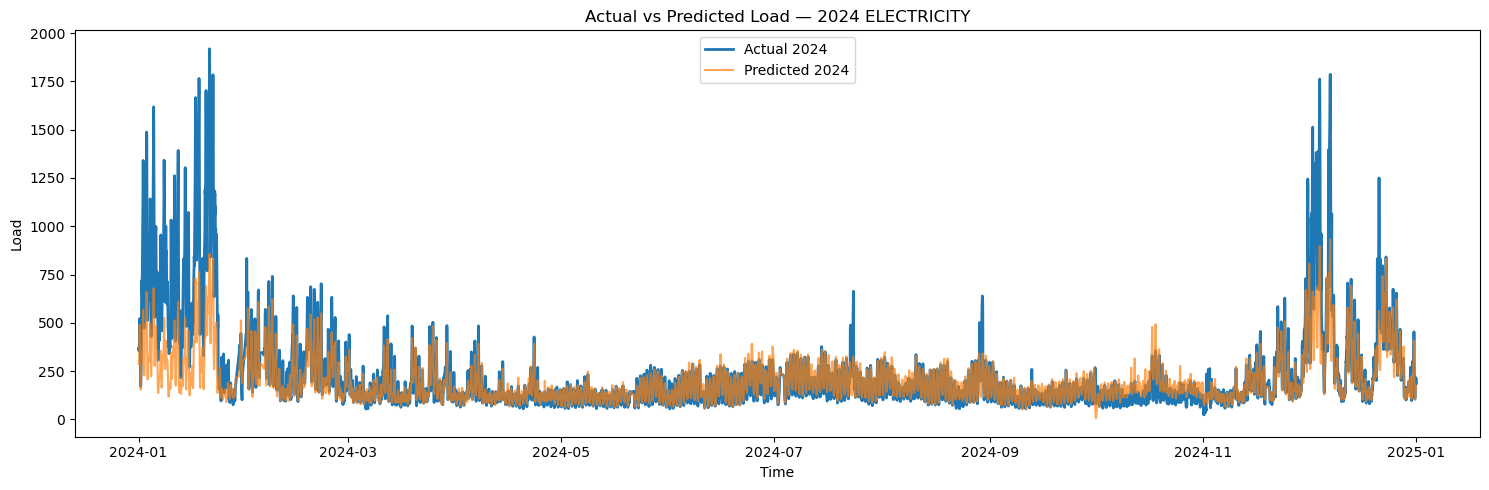

In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ---------- STEP 1: Calendar columns ----------
agg120_cleaned["date"] = agg120_cleaned["timestamp"].dt.date
agg120_cleaned["hour"] = agg120_cleaned["timestamp"].dt.hour
agg120_cleaned["year"] = agg120_cleaned["timestamp"].dt.year

# ---------- STEP 2: Train-test split ----------
train_df = agg120_cleaned[agg120_cleaned["year"] < 2024].copy()
test_df  = agg120_cleaned[agg120_cleaned["year"] == 2024].copy()

# Remove missing
train_df = train_df.dropna(subset=["load"])
test_df  = test_df.dropna(subset=["load"])

# Remove zero loads ONLY in training
train_df_nozero = train_df[train_df["load"] != 0].copy()

# ---------- STEP 3: Build X_train, Y_train ----------
drop_cols = ["timestamp", "year", "date"]

X_train = train_df_nozero.drop(columns=drop_cols + ["load"])
Y_train = train_df_nozero["load"]

X_train = X_train.select_dtypes(include=[np.number])  # Keep numeric only

# ---------- STEP 4: Build X_test for 2024 ----------
X_test = test_df.drop(columns=drop_cols + ["load"])
y_test = test_df["load"]

X_test = X_test.select_dtypes(include=[np.number])

# ---------- STEP 5: Train model ----------
model = LinearRegression()
model.fit(X_train, Y_train)

# ---------- STEP 6: Predict 2024 ----------
y_pred_test = model.predict(X_test)

# Save results in test_df
test_df["predicted"] = y_pred_test
test_df["APE"] = np.abs(test_df["predicted"] - test_df["load"]) / test_df["load"] * 100

MAPE_2024 = test_df["APE"].mean()
print(f"MAPE for 2024 predictions = {MAPE_2024:.2f}%")

plt.figure(figsize=(15,5))
plt.plot(test_df["timestamp"], test_df["load"], label="Actual 2024", linewidth=2)
plt.plot(test_df["timestamp"], test_df["predicted"], label="Predicted 2024", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Load")
plt.title("Actual vs Predicted Load — 2024 ELECTRICITY")
plt.legend()
plt.tight_layout()
plt.show()
